# Exploring Clusters

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import wrangle as w
import explore as ex

# supress scientific notation
np.set_printoptions(suppress=True)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

I cluster multiple variables in order to be able to explore and understand my data better. As an example, in the Zillow dataset:

1. Cluster by bedrooms, bathrooms and square feet to understand the different groups of combinations.

2. Plot 2 dimensions, such at logerror and lot size, and color by cluster id to see multiple dimensions in a single plot and understand the interaction of all these variables on your target, logerror in this case, a bit better.

3. Use the clusters to run an anova to see if there is a significant difference in the log error among these groups.

4. If there is a difference, what can we learn? What are the specs of the clusters with significantly higher or lower errors?



In [4]:
train, validate, test = w.wrangle_zillow()

train --> (37574, 25)
validate --> (16104, 25)
test --> (13420, 25)


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37574 entries, 67130 to 18761
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   parcelid                      37574 non-null  int64         
 1   bathroomcnt                   37574 non-null  float64       
 2   bedroomcnt                    37574 non-null  float64       
 3   calculatedfinishedsquarefeet  37574 non-null  float64       
 4   fips                          37574 non-null  float64       
 5   latitude                      37574 non-null  float64       
 6   longitude                     37574 non-null  float64       
 7   poolcnt                       37574 non-null  float64       
 8   propertycountylandusecode     37574 non-null  object        
 9   propertylandusetypeid         37574 non-null  float64       
 10  propertylandusedesc           37574 non-null  object        
 11  rawcensustractandblock  

In [11]:
def scale_this(X_df, scalertype):
    '''
    X_df = dataframe with columns you need scaled
    scalertype = something like StandardScaler(), or MinMaxScaler()
    This function takes a dataframe (an X data), a scaler, and ouputs a new dataframe with those columns scaled. 
    And a scaler to inverse transforming
    '''
    scaler = scalertype.fit(X_df)

    X_scaled = pd.DataFrame(scaler.transform(X_df), columns = X_df.columns).set_index([X_df.index.values])
    
    return X_scaled, scaler

In [18]:
def create_cluster(df, X_df, n_clusters, scaler = MinMaxScaler()):
    """ 
    Takes in df, X (dataframe with variables you want to cluster on) and n_clusters
    Default Scaler arguement is MinMaxScaler() 
    It scales the X, calcuates the clusters and return train (with clusters), the Scaled dataframe,
    the scaler and kmeans object and unscaled centroids as a dataframe
    
    returns 5 THINGS df, X_scaled, scaler, kmeans, centroids
    """
    
    X_scaled, scaler = scale_this(X_df, scaler)
    
    kmeans = KMeans(n_clusters = n_clusters, random_state = 713)
    
    kmeans.fit(X_scaled)
    
    kmeans.predict(X_scaled)
    
    df['cluster'] = kmeans.predict(X_scaled)
    
    df['cluster'] = 'cluster_' + df.cluster.astype(str)
    
    centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
    
    return df, X_scaled, scaler, kmeans, centroids
    

In [13]:
def create_scatter_plot(x, y, df, kmeans, X_scaled, scaler):
    """ 
    Takes in x and y (variable names as strings, if more than 2 variables in kmeans just pick 2)
    df = A dataframe to pull from
    kmeans cluster object and scaler (for inverse transforming)
    X_scaled dataframe
    function create_cluster and creates a scatter plot with the centroids plotted
    """
    # set fig size
    plt.figure(figsize=(10, 6))
    
    # use x and y and data inputs in seaborn for plotting scatterplot
    sns.scatterplot(x = x, y = y, data = df, hue = 'cluster')
    
    # create centroids that aren't scaled
    centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
    
    # plot centroids on top of scatter
    centroids.plot.scatter(y=y, x= x, ax=plt.gca(), alpha=.30, s=500, c='black', marker = 'x')

In [14]:
# create X_train df
X_train = train[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet']]

In [19]:
train, X_train_scaled, scaler, kmeans, centroids = create_cluster(train, X_train, 5)

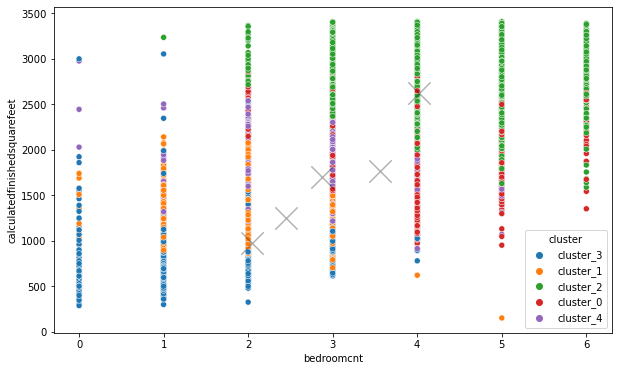

In [23]:
create_scatter_plot('bedroomcnt', 'calculatedfinishedsquarefeet', train, kmeans, X_train_scaled, scaler)